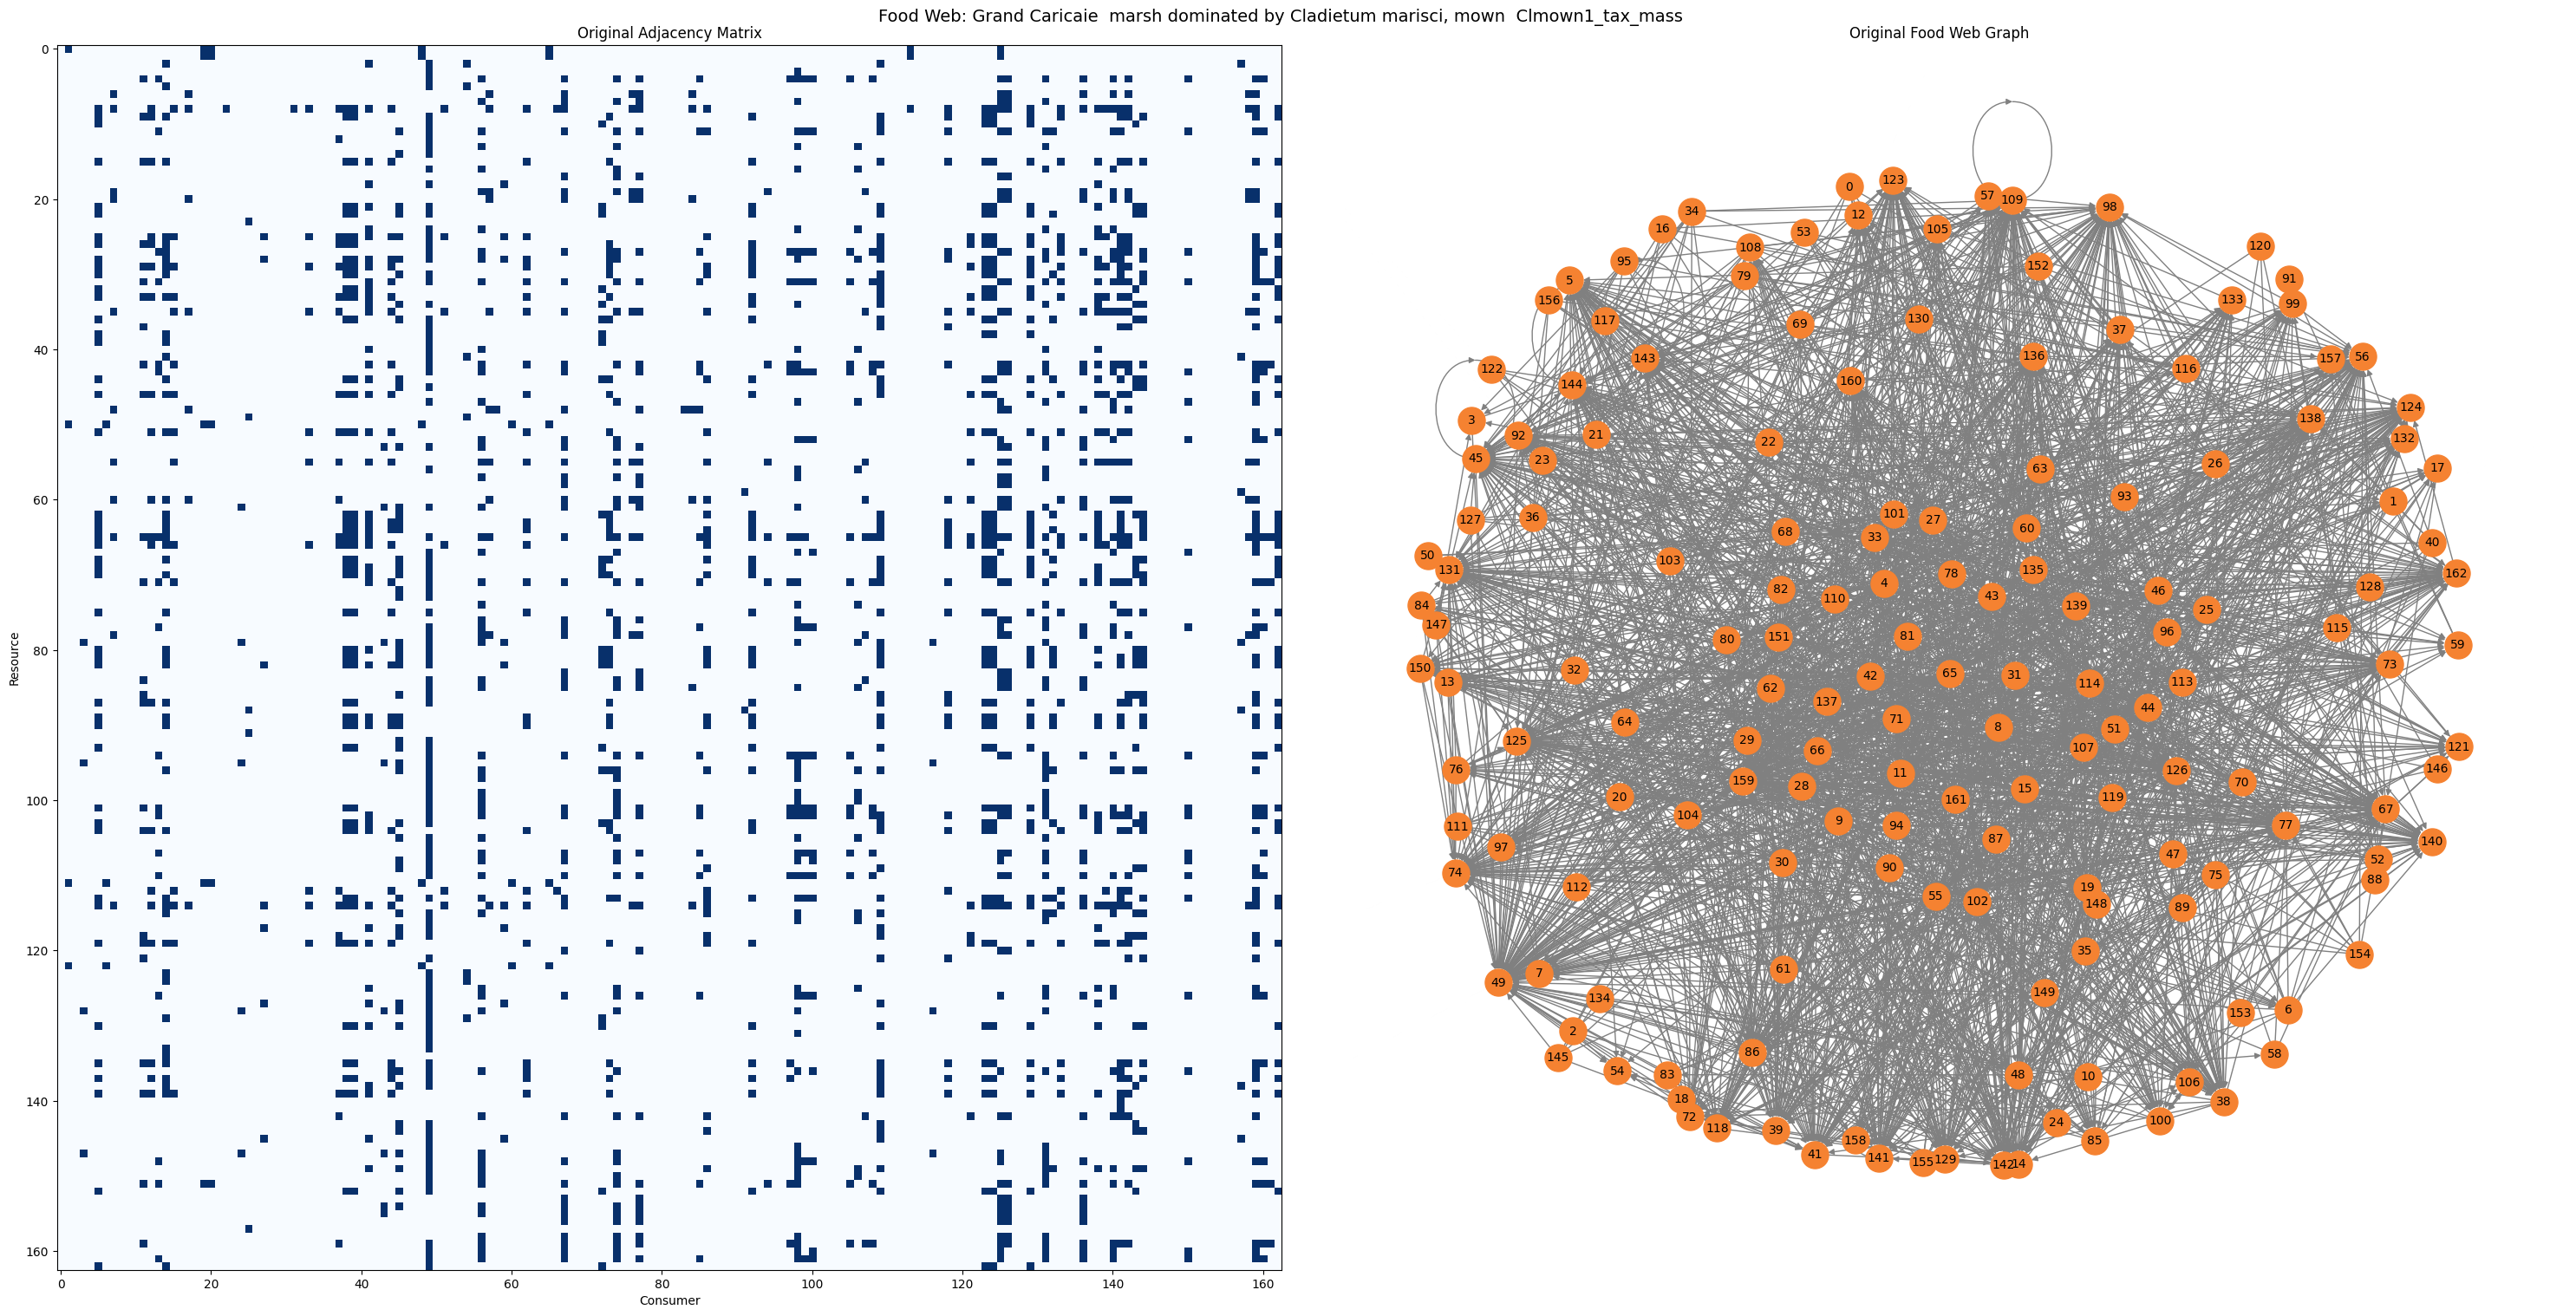

In [4]:
import scipy.io
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import issparse

def sanitize_matrix(mat):
    """Ensure input is a dense float numpy array from any sparse or object structure."""
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

# === Load food web ===
mat_path = "../../src/matlab/data/foodwebs_mat/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass.mat"
mat = scipy.io.loadmat(mat_path)

# === Extract matrices ===
adj = sanitize_matrix(mat.get("net"))
taxonomy = mat.get("taxonomy", None)
mass = mat.get("mass", None)

# === Build graph ===
G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
pos = nx.spring_layout(G, seed=42, k=1.5)  # Fixed layout for reproducibility

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle(f'Food Web: {mat_path.split("/")[-1].replace(".mat", "")}', fontsize=14)

# LEFT: Adjacency Matrix
axes[0].imshow(adj, cmap="Blues", interpolation="none")
axes[0].set_title("Original Adjacency Matrix")
axes[0].set_xlabel("Consumer")
axes[0].set_ylabel("Resource")
# axes[0].set_xticks(np.arange(adj.shape[0]))
# axes[0].set_yticks(np.arange(adj.shape[0]))
# axes[0].set_xticklabels(np.arange(adj.shape[0]))
# axes[0].set_yticklabels(np.arange(adj.shape[0]))

# RIGHT: Network Graph
nx.draw(G, pos, ax=axes[1], with_labels=True, node_color='#f58231', node_size=500, edge_color='gray', arrows=True, font_size=10)
axes[1].set_title("Original Food Web Graph")

plt.tight_layout()
plt.show()

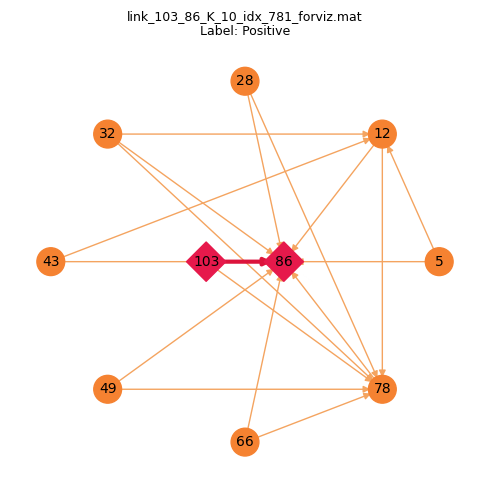

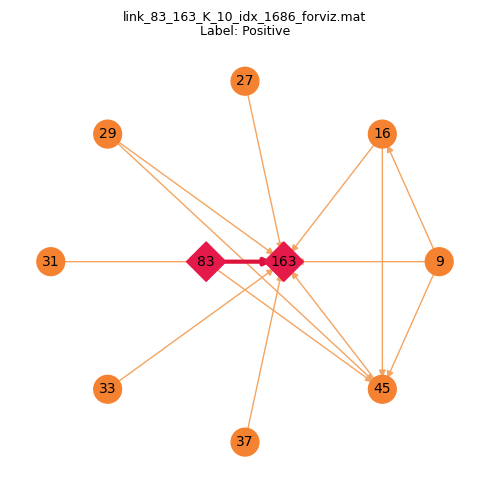

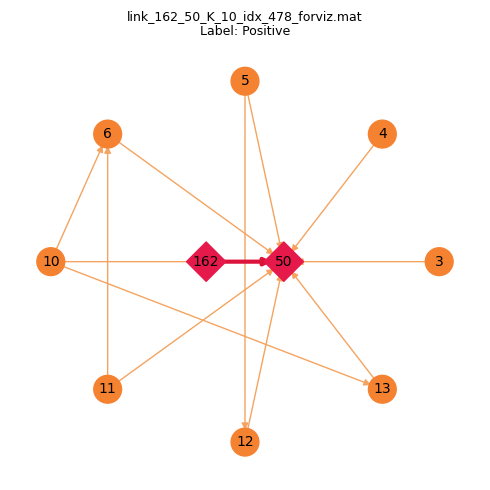

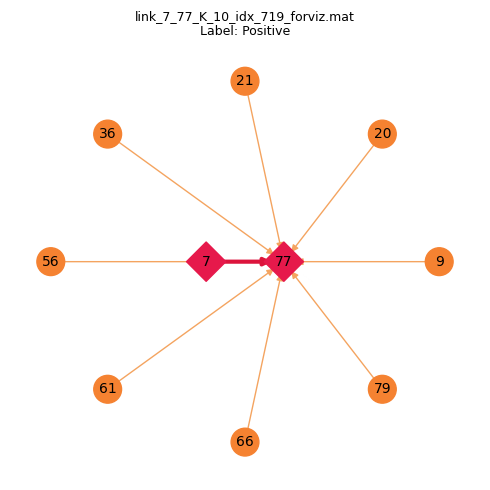

In [18]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse
from math import pi, cos, sin

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    """
    Generate a custom layout with source and target centered, and other nodes around.
    """
    nodes = list(G.nodes())
    source, target = link

    # Initial positions for source and target
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }

    # Get remaining nodes
    remaining = [n for n in nodes if n not in link]
    n = len(remaining)
    if n == 0:
        return pos

    angles = np.linspace(0, 2 * pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])

    return pos

def visualize_building_block(mat_file_path, mode="before", positive_only=True):
    mat = scipy.io.loadmat(mat_file_path)

    label = int(mat.get('label', [[0]])[0][0])
    if positive_only and label != 1:
        return

    adj_key = {
        "before": "adj_before",
        "after": "adj_after",
        "ordered": "ordered_adj"
    }.get(mode, "adj_before")

    if adj_key not in mat or mat[adj_key].size == 0:
        print(f"⛔️ Skipping {os.path.basename(mat_file_path)}: '{adj_key}' missing or empty.")
        return

    adj = sanitize_matrix(mat[adj_key])
    if adj.ndim != 2:
        print(f"⛔️ Skipping {os.path.basename(mat_file_path)}: '{adj_key}' not 2D. Got shape: {adj.shape}")
        return

    if 'nodes' not in mat:
        print(f"⛔️ Skipping {os.path.basename(mat_file_path)}: 'nodes' missing.")
        return
    nodes = [int(x) for x in mat['nodes'].flatten()]

    link_global = tuple(int(x) for x in mat.get('link', [[0, 0]]).flatten())
    if link_global[0] not in nodes or link_global[1] not in nodes:
        print(f"⚠️ Skipping {os.path.basename(mat_file_path)}: link {link_global} not in 'nodes'.")
        return

    # Construir el grafo respetando IDs
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, source in enumerate(nodes):
        for j, target in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(source, target)

    # Layout centrado en el link
    pos = centered_layout(G, link=link_global, radius=2.5)

    # Estilos visuales
    highlighted_nodes = {link_global[0], link_global[1]}
    node_colors = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(5, 5))
    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_colors[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist,
                               node_shape=shape, node_size=400, ax=ax)

    normal_edges = [e for e in G.edges() if e != link_global]
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link_global], edge_color='crimson', width=3, arrows=True, ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title(f"{os.path.basename(mat_file_path)}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Procesar archivos ===
folder_path = "../../src/matlab/data/result/building_blocks/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
mat_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]
mat_paths = mat_paths[:30]

for path in mat_paths:
    visualize_building_block(path, positive_only=True)

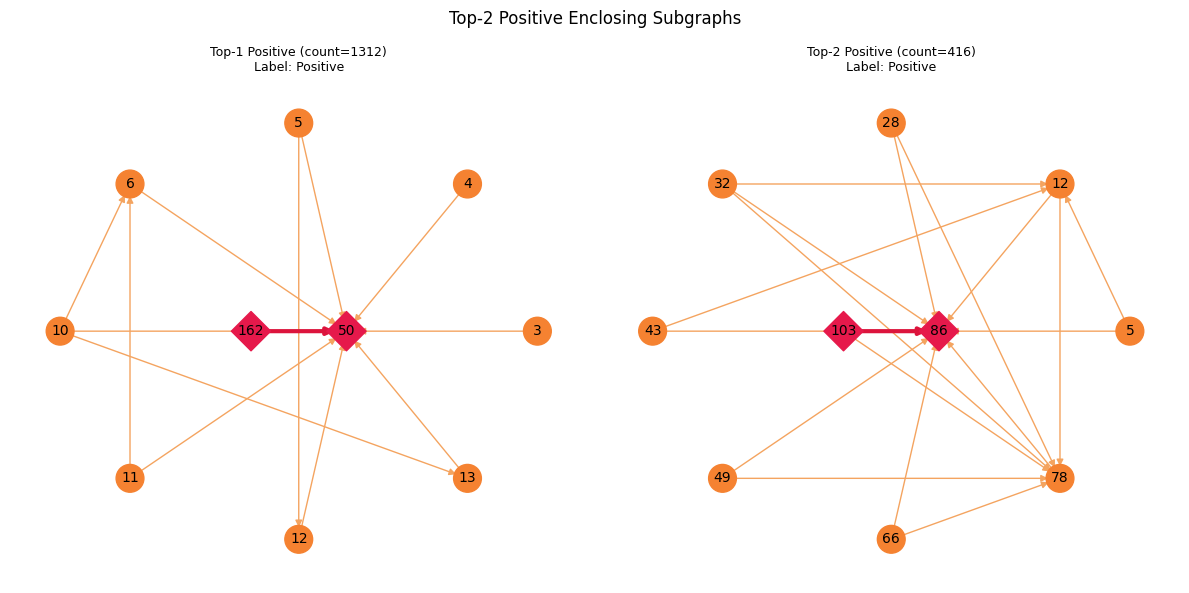

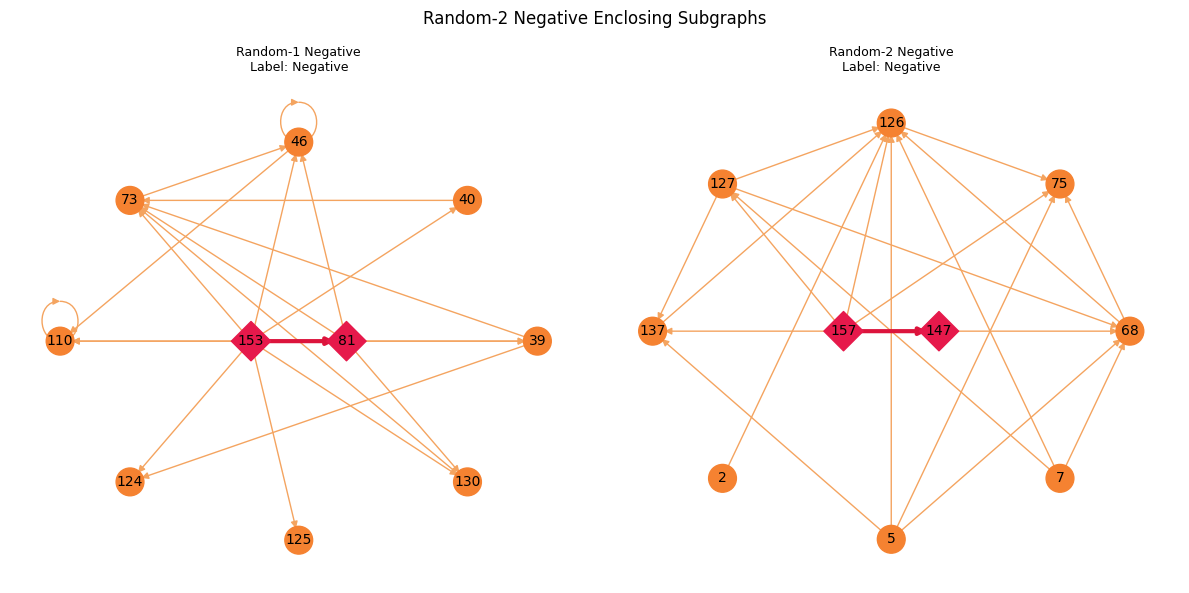

In [9]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.sparse import issparse
from collections import Counter
from math import pi, cos, sin

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)

    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_colors = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]

    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_colors[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist,
                               node_shape=shape, node_size=400, ax=ax)

    normal_edges = [e for e in G.edges() if e != link]
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_graphs(subgraphs, titles, suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for i, (adj, nodes, link, label) in enumerate(subgraphs):
        draw_graph_on_ax(adj, nodes, link, label, titles[i], axes[i])
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

# === Cargar todos los .mat ===
folder_path = "../../src/matlab/data/result/building_blocks/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
mat_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs = {}
negative_subgraphs = []

for path in mat_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    flat_hash = np.nan_to_num(ordered_adj.flatten(), nan=0.0, posinf=0.0, neginf=0.0).astype(int)
    hash_key = tuple(flat_hash)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# === Top 2 positivos ===
most_common_positives = positive_counter.most_common(2)
positive_to_plot = []
positive_titles = []

for i, (hash_key, count) in enumerate(most_common_positives, 1):
    data = positive_subgraphs[hash_key]
    positive_to_plot.append(data)
    positive_titles.append(f"Top-{i} Positive (count={count})")

# === 2 negativos aleatorios ===
random_negatives = random.sample(negative_subgraphs, min(2, len(negative_subgraphs)))
negative_titles = [f"Random-{i+1} Negative" for i in range(len(random_negatives))]

# === Mostrar figuras ===
plot_graphs(positive_to_plot, positive_titles, "Top-2 Positive Enclosing Subgraphs")
plot_graphs(random_negatives, negative_titles, "Random-2 Negative Enclosing Subgraphs")

In [17]:
positive_counter[hash_key]

416

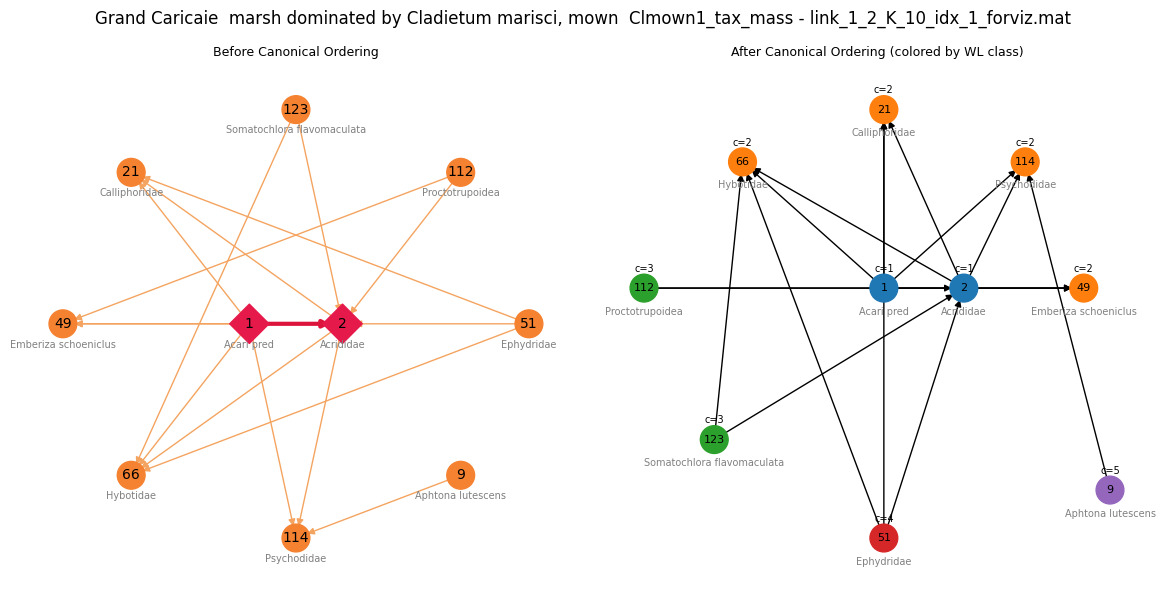

In [8]:
import scipy.io
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

# === Load .mat files ===
foodweb_name = "Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
mat_block_name = "link_1_2_K_10_idx_1_forviz.mat"
mat_block = scipy.io.loadmat("../../src/matlab/data/result/building_blocks/" + foodweb_name + "/" + mat_block_name)
mat_full = scipy.io.loadmat("../../src/matlab/data/foodwebs_mat/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass.mat")

A_before = mat_block["adj_before"]
A_after = mat_block["adj_after"]
nodes = mat_block["nodes"].flatten()
nodes_ordered = mat_block["nodes_ordered"].flatten()
classes = mat_block["classes"].flatten()
link = mat_block["link"].flatten()
pred, prey = map(int, link)

taxonomy_raw = mat_full["taxonomy"]
taxonomy = [str(t[0]) for t in taxonomy_raw[0]]

G1 = nx.from_numpy_array(A_before, create_using=nx.DiGraph)
G2 = nx.from_numpy_array(A_after, create_using=nx.DiGraph)

mapping_before = {i: int(nodes[i]) for i in range(len(nodes))}
mapping_after = {i: int(nodes_ordered[i]) for i in range(len(nodes_ordered))}
G1 = nx.relabel_nodes(G1, mapping_before)
G2 = nx.relabel_nodes(G2, mapping_after)

# === Coloring G1 ===
highlighted_nodes = {pred, prey}
node_colors_G1 = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G1.nodes()]
node_shapes_G1 = ['D' if n in highlighted_nodes else 'o' for n in G1.nodes()]

# === Coloring G2 by WL class ===
def get_node_colors_by_classes(classes):
    unique_classes = np.unique(classes)
    cmap = plt.get_cmap("tab10") if len(unique_classes) <= 10 else plt.get_cmap("tab20")
    color_map = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_classes)}
    return [color_map[c] for c in classes]

colors_G2 = get_node_colors_by_classes(classes)

# === Layout G1: pred/prey centered, rest in circle ===
def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * math.pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * math.cos(angles[i]), radius * math.sin(angles[i])])
    return pos

pos1 = centered_layout(G1, link)

# === Layout G2: pred/prey centered, rest by WL class ===
center_pred = (0.0, 0.0)
center_prey = (1.0, 0.0)
radius_base = 1.5

pos2 = {pred: center_pred, prey: center_prey}
rest_nodes = [n for i, n in enumerate(G2.nodes()) if n not in (pred, prey)]
rest_classes = [classes[i] for i, n in enumerate(G2.nodes()) if n not in (pred, prey)]
angle_step = 2 * math.pi / len(rest_nodes) if rest_nodes else 0

for i, node in enumerate(rest_nodes):
    c = rest_classes[i]
    radius = radius_base + 0.5 * c
    angle = i * angle_step
    x = radius * math.cos(angle)
    y = radius * math.sin(angle)
    pos2[node] = (x, y)

# === Plot ===
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(foodweb_name + " - " + mat_block_name, fontsize=12)

# === Plot G1 ===
for shape in set(node_shapes_G1):
    nodelist = [n for n, s in zip(G1.nodes(), node_shapes_G1) if s == shape]
    colorlist = [node_colors_G1[list(G1.nodes()).index(n)] for n in nodelist]
    nx.draw_networkx_nodes(G1, pos1, nodelist=nodelist, node_color=colorlist,
                           node_shape=shape, node_size=400, ax=axs[0])

normal_edges_G1 = [e for e in G1.edges() if e != (pred, prey)]
nx.draw_networkx_edges(G1, pos1, edgelist=normal_edges_G1, edge_color='sandybrown', arrows=True, ax=axs[0])

if G1.has_edge(pred, prey):
    nx.draw_networkx_edges(G1, pos1, edgelist=[(pred, prey)], edge_color='crimson', width=3, arrows=True, ax=axs[0])
else:
    print(f"⚠️ Link not found in G1: ({pred} → {prey})")

nx.draw_networkx_labels(G1, pos1, ax=axs[0], font_size=10)
for node in G1.nodes():
    x, y = pos1[node]
    name = taxonomy[node] if 0 <= node < len(taxonomy) else str(node)
    axs[0].text(x, y - 0.3, name, fontsize=7, ha='center', va='bottom', color='grey')

axs[0].set_title("Before Canonical Ordering", fontsize=9)
axs[0].axis("off")

# === Plot G2 ===
nx.draw_networkx_nodes(G2, pos2, ax=axs[1], node_color=colors_G2, node_size=400)
nx.draw_networkx_edges(G2, pos2, ax=axs[1], arrows=True)
nx.draw_networkx_labels(G2, pos2, ax=axs[1], font_size=8)

for i, node in enumerate(G2.nodes()):
    x, y = pos2[node]
    name = taxonomy[node] if 0 <= node < len(taxonomy) else str(node)
    axs[1].text(x, y + 0.2, f"c={classes[i]}", fontsize=7, ha='center', va='bottom', color='black')
    axs[1].text(x, y - 0.4, name, fontsize=7, ha='center', va='bottom', color='grey')

axs[1].set_title("After Canonical Ordering (colored by WL class)", fontsize=9)
axs[1].axis("off")

plt.tight_layout()
plt.show()

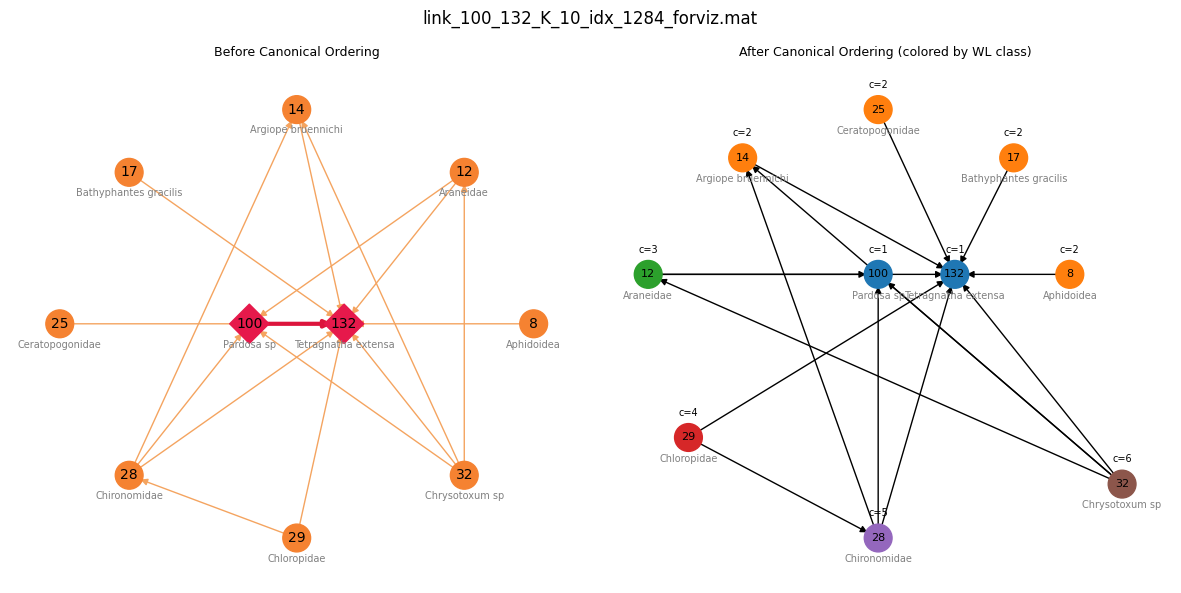

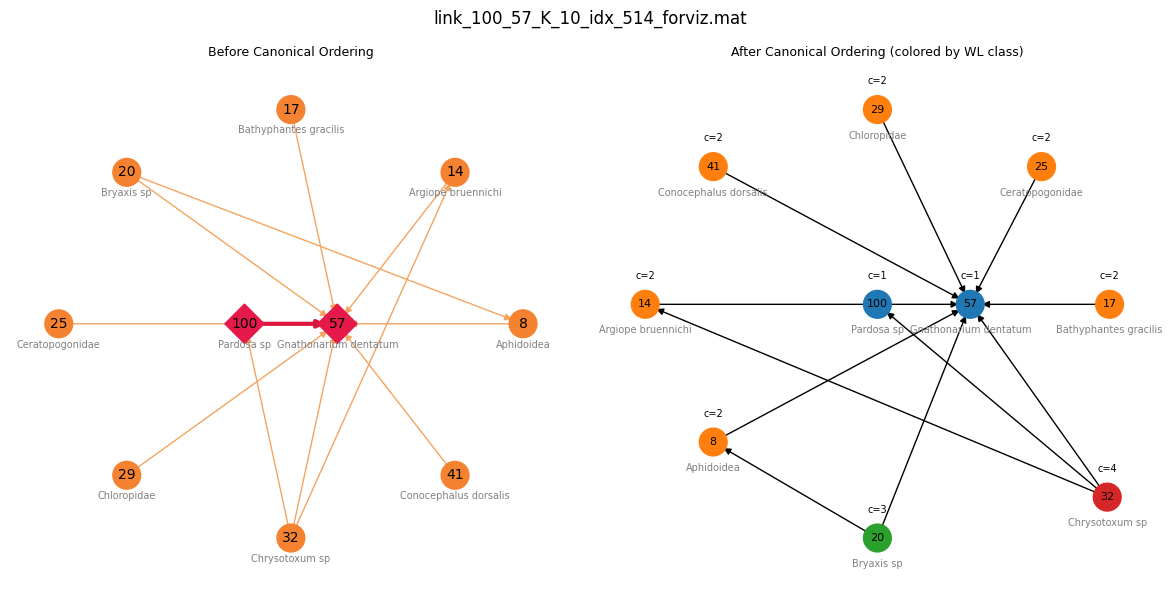

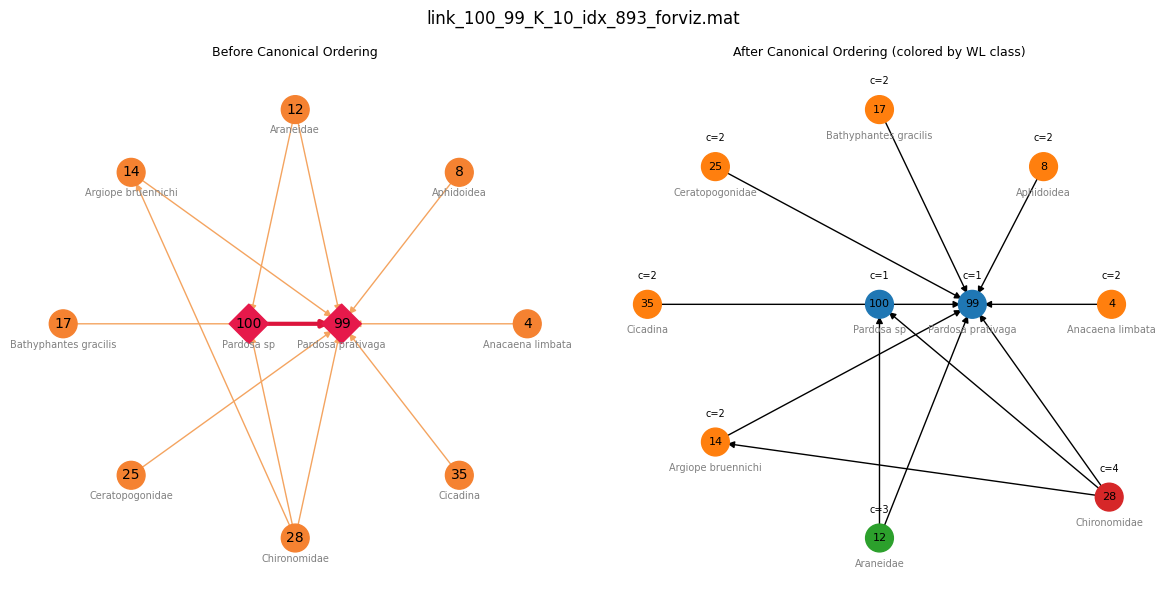

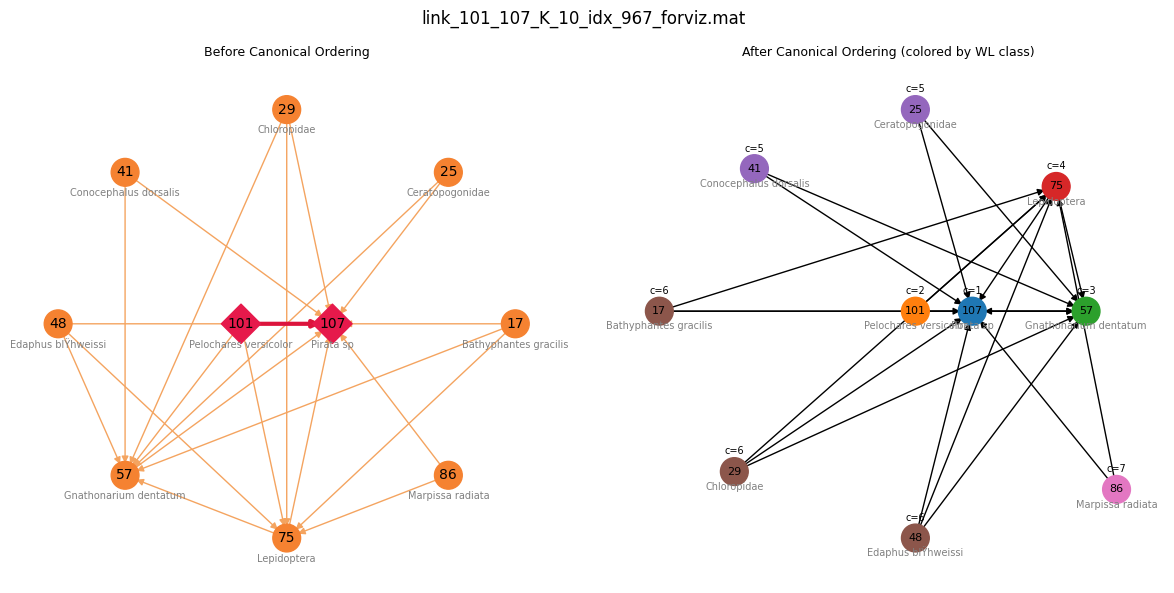

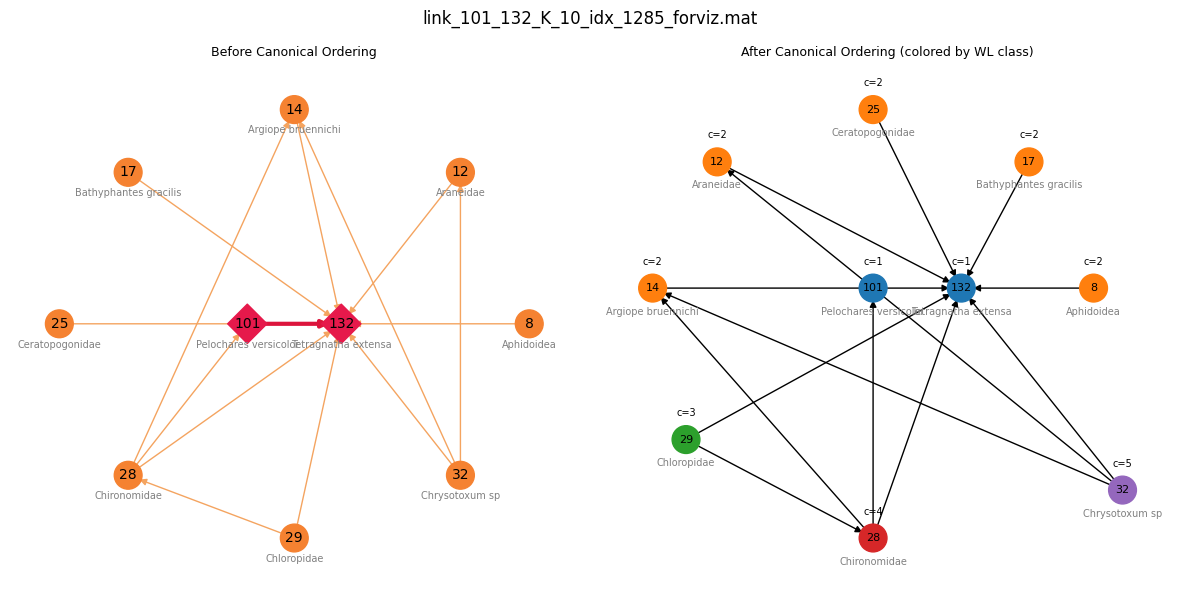

In [3]:
import os
import scipy.io
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

# Función de colores por clase WL
def get_node_colors_by_classes(classes):
    unique_classes = np.unique(classes)
    cmap = plt.get_cmap("tab10") if len(unique_classes) <= 10 else plt.get_cmap("tab20")
    color_map = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_classes)}
    return [color_map[c] for c in classes]

# Layout centrado para G1
def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * math.pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * math.cos(angles[i]), radius * math.sin(angles[i])])
    return pos

# Función principal de visualización
def visualize_subgraph_pair(mat_block_path, mat_full_path):
    mat_block = scipy.io.loadmat(mat_block_path)
    required_keys = ['adj_before', 'adj_after', 'nodes', 'nodes_ordered', 'classes', 'link', 'label']
    if not all(k in mat_block for k in required_keys):
        print(f"⚠️ Skipping incomplete: {os.path.basename(mat_block_path)}")
        return

    label = int(mat_block["label"].flatten()[0])
    if ONLY_POSITIVES and label == 0:
        return

    A_before = mat_block["adj_before"]
    A_after = mat_block["adj_after"]
    nodes = mat_block["nodes"].flatten()
    nodes_ordered = mat_block["nodes_ordered"].flatten()
    classes = mat_block["classes"].flatten()
    link = mat_block["link"].flatten()
    pred, prey = map(int, link)

    # Cargar metadata del food web completo
    if not os.path.exists(mat_full_path):
        print(f"⛔️ Foodweb file missing: {mat_full_path}")
        return
    mat_full = scipy.io.loadmat(mat_full_path)
    taxonomy_raw = mat_full.get("taxonomy")
    if taxonomy_raw is None:
        print(f"⛔️ 'taxonomy' missing in {mat_full_path}")
        return
    taxonomy = [str(t[0]) for t in taxonomy_raw[0]]

    G1 = nx.from_numpy_array(A_before, create_using=nx.DiGraph)
    G2 = nx.from_numpy_array(A_after, create_using=nx.DiGraph)
    mapping_before = {i: int(nodes[i]) for i in range(len(nodes))}
    mapping_after = {i: int(nodes_ordered[i]) for i in range(len(nodes_ordered))}
    G1 = nx.relabel_nodes(G1, mapping_before)
    G2 = nx.relabel_nodes(G2, mapping_after)

    # Omitir subgrafos donde el link no existe
    if not G1.has_edge(pred, prey):
        # print(f"⏭️  Skipping: link ({pred} → {prey}) not in G1 for {os.path.basename(mat_block_path)}")
        return

    highlighted_nodes = {pred, prey}
    node_colors_G1 = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G1.nodes()]
    node_shapes_G1 = ['D' if n in highlighted_nodes else 'o' for n in G1.nodes()]
    colors_G2 = get_node_colors_by_classes(classes)

    pos1 = centered_layout(G1, link)
    center_pred = (0.0, 0.0)
    center_prey = (1.0, 0.0)
    radius_base = 1.5
    pos2 = {pred: center_pred, prey: center_prey}
    rest_nodes = [n for i, n in enumerate(G2.nodes()) if n not in (pred, prey)]
    rest_classes = [classes[i] for i, n in enumerate(G2.nodes()) if n not in (pred, prey)]
    angle_step = 2 * math.pi / len(rest_nodes) if rest_nodes else 0

    for i, node in enumerate(rest_nodes):
        c = rest_classes[i]
        radius = radius_base + 0.5 * c
        angle = i * angle_step
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        pos2[node] = (x, y)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for shape in set(node_shapes_G1):
        nodelist = [n for n, s in zip(G1.nodes(), node_shapes_G1) if s == shape]
        colorlist = [node_colors_G1[list(G1.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G1, pos1, nodelist=nodelist, node_color=colorlist,
                               node_shape=shape, node_size=400, ax=axs[0])

    normal_edges_G1 = [e for e in G1.edges() if e != (pred, prey)]
    nx.draw_networkx_edges(G1, pos1, edgelist=normal_edges_G1, edge_color='sandybrown', arrows=True, ax=axs[0])
    if G1.has_edge(pred, prey):
        nx.draw_networkx_edges(G1, pos1, edgelist=[(pred, prey)], edge_color='crimson', width=3, arrows=True, ax=axs[0])

    nx.draw_networkx_labels(G1, pos1, ax=axs[0], font_size=10)
    for node in G1.nodes():
        x, y = pos1[node]
        name = taxonomy[node] if 0 <= node < len(taxonomy) else str(node)
        axs[0].text(x, y - 0.3, name, fontsize=7, ha='center', va='bottom', color='grey')

    axs[0].set_title("Before Canonical Ordering", fontsize=9)
    axs[0].axis("off")

    nx.draw_networkx_nodes(G2, pos2, ax=axs[1], node_color=colors_G2, node_size=400)
    nx.draw_networkx_edges(G2, pos2, ax=axs[1], arrows=True)
    nx.draw_networkx_labels(G2, pos2, ax=axs[1], font_size=8)
    for i, node in enumerate(G2.nodes()):
        x, y = pos2[node]
        name = taxonomy[node] if 0 <= node < len(taxonomy) else str(node)
        axs[1].text(x, y + 0.3, f"c={classes[i]}", fontsize=7, ha='center', va='bottom', color='black')
        axs[1].text(x, y - 0.4, name, fontsize=7, ha='center', va='bottom', color='grey')

    axs[1].set_title("After Canonical Ordering (colored by WL class)", fontsize=9)
    axs[1].axis("off")
    fig.suptitle(os.path.basename(mat_block_path), fontsize=12)
    plt.tight_layout()
    plt.show()

# Configuración
ONLY_POSITIVES = True
LIMIT = 8  # Limitar la cantidad de visualizaciones
foodweb_name = "Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
building_blocks_dir = f"../../src/matlab/data/result/building_blocks/{foodweb_name}"
mat_full_path = f"../../src/matlab/data/foodwebs_mat/{foodweb_name}.mat"

# Ejecutar visualización para archivos limitados
mat_files = sorted([os.path.join(building_blocks_dir, f) for f in os.listdir(building_blocks_dir) if f.endswith(".mat")])[:LIMIT]
for path in mat_files:
    visualize_subgraph_pair(path, mat_full_path)

## **Initial Proposal: Predicting Unknown Links Using Unsupervised Learning**

### Objective

Explore **unsupervised learning** methods to detect **potential (missing) links** in food web networks without relying on explicit labels (`label=0/1`). The goal is to capture structural patterns (e.g., structural similarity, embeddings, motifs) that indicate the likelihood of interaction between pairs of nodes.

## Viable Approaches

### 1. **Unsupervised Graph Embeddings**

Generate vector representations (embeddings) of nodes using methods such as:

* **Node2Vec / DeepWalk / LINE**: Random walks + SkipGram to learn node representations. Then, node pairs with similar vectors are candidates for links.
* **HOPE / SDNE / Graph AutoEncoders**: Preserve structural proximity.
* **GraphSAGE (unsupervised)**: An inductive version with structural aggregators.

**Prediction**: After obtaining the vectors, compute similarity (cosine, L2, etc.) between nodes to rank potential links.

### 2. **Graph AutoEncoders (GAE / VGAE)**

Neural networks are used to reconstruct the adjacency matrix from latent embeddings:

* A GCN encoder learns node embeddings.
* A decoder reconstructs connections between nodes.

> **No labels required**, and missing links are predicted as reconstruction errors.

Examples:

* Kipf & Welling (2016): [*"Variational Graph Auto-Encoders"*](https://arxiv.org/abs/1611.07308)
* Salha et al. (2020): [*"Simple and Effective Graph Autoencoders with One-Hop Linear Models"*](https://dl.acm.org/doi/10.1007/978-3-030-67658-2_19)

### 3. **Motif-based Link Prediction (Directed Motifs)**

Exploit repeated structural patterns (triangles, paths, directed subgraphs) as signatures to infer links.

* Count how often node pairs appear in key structures.
* Techniques like **RoleSim**, **SimRank**, or **motif2vec** help encode functional or structural relationships without labels.

### 4. **Clustering + Heuristic-Based Prediction**

1. Cluster nodes by topological, taxonomic, or trophic similarity (e.g., mass, role).
2. Infer potential *intra-* or *inter-cluster* links using:

   * proximity in embedding space
   * trophic level differences
   * conditional probability heuristics

## Comparison with WLNM

| Approach              | Supervised | Requires Labels  | Scalable | Interpretable   | Direct Prediction        |
| --------------------- | ---------- | ---------------- | -------- | --------------- | ------------------------ |
| WLNM                  | Yes        | Yes (labels 0/1) | Medium   | Yes (subgraphs) | Yes                      |
| GAE / VGAE            | No         | No               | Medium   | Partial         | Yes (via reconstruction) |
| Node2Vec + Similarity | No         | No               | High     | Partial         | Yes (via ranking)        |
| Motif-based           | No         | No               | Medium   | Yes             | Yes                      |

I propose an exploratory experiment where I use **GAE** or **Node2Vec + cosine similarity** as an unsupervised baseline, and then compare its AUC/AP with WLNM on small food webs.


---

## **Initial Proposal: Predicting Unknown Links Using Unsupervised Learning**

We want to **revisit the preprint** to:

1. **Understand their method of identifying missing links** — especially how they define “target” links (i.e. those added to an incomplete food web).
2. **Assess whether I can extract those missing links from their dataset** to serve as ground truth in a **comparative test with WLNM implementation**.

Essentially: **Can we reuse their labels or reconstructed links to benchmark WLNM** under the same data conditions?

### What the preprint does (summary):

* The authors **simulate missing links** by **deleting known interactions** from a food web (randomly or in a structured way) and then try to **predict them back** using a **stacked ensemble model**.
* They combine **multiple predictors**:

  * **Traits** (e.g., body mass, taxonomic distance),
  * **Network structure metrics** (e.g., shortest paths, common neighbors),
  * **Environmental overlap**,
  * And **geographic co-occurrence**.
* The **stacked model** uses a **supervised learning paradigm**: true links are positives, and randomly sampled unlinked pairs are negatives.

### How missing links (targets) are defined:

From the paper (Section 2.3, "Link removal and model testing"):

> *“We randomly removed a proportion of true interactions from the observed network and then evaluated how well each model predicted the removed links.”*

This is crucial: **they generate known ground truth positives** (removed links) and **evaluate models on their ability to recover them**. These links **can be reused** for your WLNM evaluation.

### What I can do:

#### 1. **Download or recreate the exact networks they used**

* Check if author's [supplementary materials](https://www.biorxiv.org/content/10.1101/2024.11.22.624890v1.supplementary-material):
  * Supplemental Data File 1: Values filled in for nodes with movement type ‘NA.’
  * Supplemental Data File 2: Food web features across the database.
  * Supplemental Data File 3: Summary statistics for food web features split by ecosystem type.

#### 2. **Reconstruct their evaluation set**:

* For each food web:

  * Keep the **original adjacency matrix** as ground truth.
  * Remove X% of links to simulate missingness (as they did).
  * Use the removed links as your **positive test set**.
  * Sample non-links as **negatives** (as I do in WLNM).

#### 3. **Run WLNM on the same split**

* Encode subgraphs as I currently do.
* Use the same positive/negative samples.
* Compare performance (AUC, precision\@k) with the models reported in the preprint.

#### 4. **(Optional) Use their feature vectors**:

* If the traits or structure-based features are available, I can **combine them with WLNM embeddings** in a hybrid stacked model.


This will let me **validate WLNM on the same benchmark** used in a recent food web ML study — a strong comparative case for my methodology.